## AIM: Perform cluster analysis with extracted features, to see if features form clusters per diagnosis

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
%matplotlib widget
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in feature data

In [2]:
df_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_stat_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

ID   age  gender diagnosis  epoch  EO_frontal_delta_std  \
6305  sub-88063445    44     0.0       MDD      6              0.364080   
1045  sub-87974621  <NA>     0.0   HEALTHY      2              0.365687   
2312  sub-88020381    35     1.0       MDD      9              0.382294   
6384  sub-88064477    47     0.0      ADHD      1              0.347894   
200   sub-87966921    74     0.0       SMC      9              0.458933   
6912  sub-88068797    17     1.0      ADHD      1              0.385789   
7024  sub-88069605    31     0.0       MDD      5              0.408856   

      EO_frontal_delta_mean  EO_frontal_delta_median  EO_frontal_delta_skew  \
6305              -0.139091                -0.142670              -0.371555   
1045              -0.141463                -0.139981              -0.451189   
2312              -0.145978                -0.139085              -0.506545   
6384              -0.128037                -0.122859              -0.287791   
200               -0.219594                -0.192597              -0.313390   
6912              -0.153796                -0.155437              -0.395995   
7024              -0.174349                -0.174887              -0.381193   

      EO_frontal_delta_kurt  ...  ratio_parietal_gamma_std  \
6305               0.016803  ...                  1.043650   
1045               0.544628  ...                  0.990678   
2312               0.028625  ...                       NaN   
6384              -0.113688  ...                  1.098277   
200               -0.027566  ...                  0.787218   
6912               0.192724  ...                  1.031708   
7024               0.254822  ...                  1.311446   

      ratio_parietal_gamma_mean  ratio_parietal_gamma_median  \
6305                   1.092715                     1.005240   
1045                   0.988210                     0.957598   
2312                        NaN                          NaN   
6384                   1.280880                     1.265779   
200                    0.547300                     0.511724   
6912                   1.123453                     1.113508   
7024                   2.486323                     2.616110   

      ratio_parietal_gamma_skew  ratio_parietal_gamma_kurt  \
6305                   0.918264                   0.920631   
1045                   1.054283                   1.424153   
2312                        NaN                        NaN   
6384                   0.542635                   0.913052   
200                   20.188144                   2.283508   
6912                   0.569914                   0.736774   
7024                  -1.131167                   2.440849   

      ratio_occipital_gamma_std  ratio_occipital_gamma_mean  \
6305                   1.015488                    1.047151   
1045                   1.031357                    1.055482   
2312                        NaN                         NaN   
6384                   1.216615                    1.592632   
200                    0.724181                    0.471848   
6912                   1.128596                    1.267873   
7024                   1.160659                    1.613800   

      ratio_occipital_gamma_median  ratio_occipital_gamma_skew  \
6305                      0.976772                    0.922316   
1045                      1.020949                    1.063772   
2312                           NaN                         NaN   
6384                      1.600562                    0.406576   
200                       0.490194                  311.475603   
6912                      1.282258                    0.891594   
7024                      1.710923                   -0.089241   

      ratio_occipital_gamma_kurt  
6305                    1.403429  
1045                    1.094557  
2312                         NaN  
6384                    0.451408  
200                   -60.029443  
6912                    2.19194

In [3]:
df_features['diagnosis'].value_counts()

diagnosis
MDD        3732
ADHD       2051
SMC        1032
HEALTHY     564
OCD         540
Name: count, dtype: int64

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_features_ec = df_features[df_features.columns[~(df_features.columns.str.startswith('EO') | df_features.columns.str.startswith('ratio'))]]
df_features_eo = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('ratio'))]]
df_features_ratio = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('EO'))]]

In [5]:
# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

# Cluster analysis
for each full 'ratio', 'ec', and 'eo' feature sets a cluster analysis will be performed with n_clusters = n_diagnoses (5)

#### ratio feature set

Text(0.5, 0.92, 'Cluster centers')

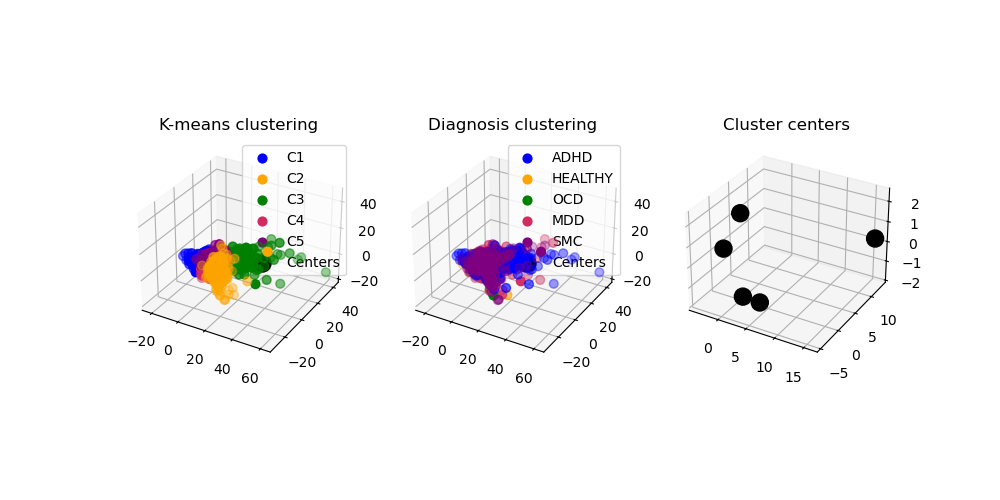

In [7]:
## K-means cluster analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

n_clusters = 5 # because 5 different classes/diagnoses

# define numeric columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

X = df_features_ratio[numeric_cols]
X_scaled = numeric_transformer.fit_transform(X)
Y = df_features_ratio['diagnosis']

# model
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled_clustered['cluster'] = clusters

from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 3 dimensions for visualisation
pca = PCA(n_components = 3)
X_reduced = pca.fit_transform(X_scaled) # transfer to 3D

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index = X.index, columns=['PC1','PC2', 'PC3'])
X_reduceddf['cluster'] = clusters

centres_reduced = pca.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,3,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_reduced[c1,0],X_reduced[c1,1],X_reduced[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_reduced[c2,0],X_reduced[c2,1],X_reduced[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_reduced[c3,0],X_reduced[c3,1],X_reduced[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_reduced[c4,0],X_reduced[c4,1],X_reduced[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_reduced[c5,0],X_reduced[c5,1],X_reduced[c5,2],c='purple',s=40,label="C5", zorder=1)
ax[0].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering')

ax[1].scatter(X_reduced[d1,0],X_reduced[d1,1],X_reduced[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_reduced[d2,0],X_reduced[d2,1],X_reduced[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_reduced[d3,0],X_reduced[d3,1],X_reduced[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_reduced[d4,0],X_reduced[d4,1],X_reduced[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_reduced[d5,0],X_reduced[d5,1],X_reduced[d5,2],c='purple',s=40,label="SMC", zorder=1)
ax[1].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

ax[2].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[2].set_title('Cluster centers')



Text(0.5, 0.92, 'Diagnosis clustering')

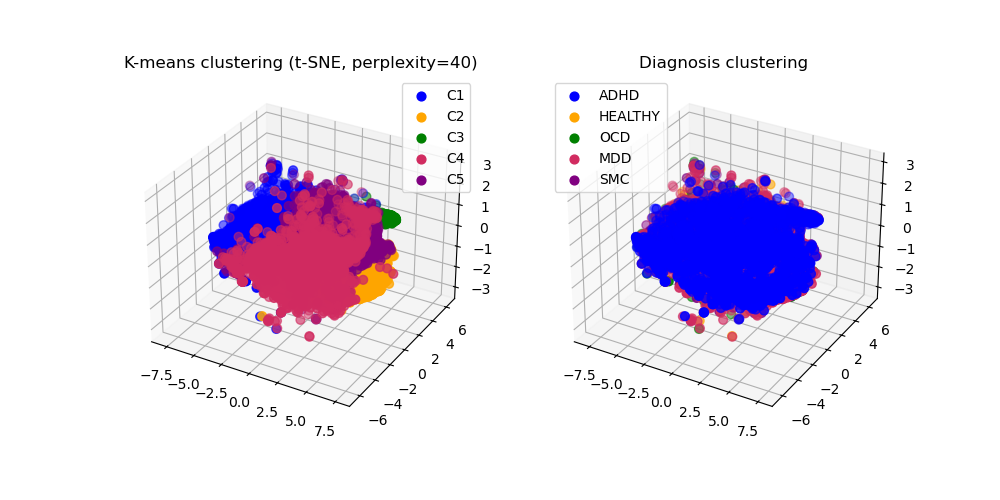

In [21]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 0.92, 'Diagnosis clustering')

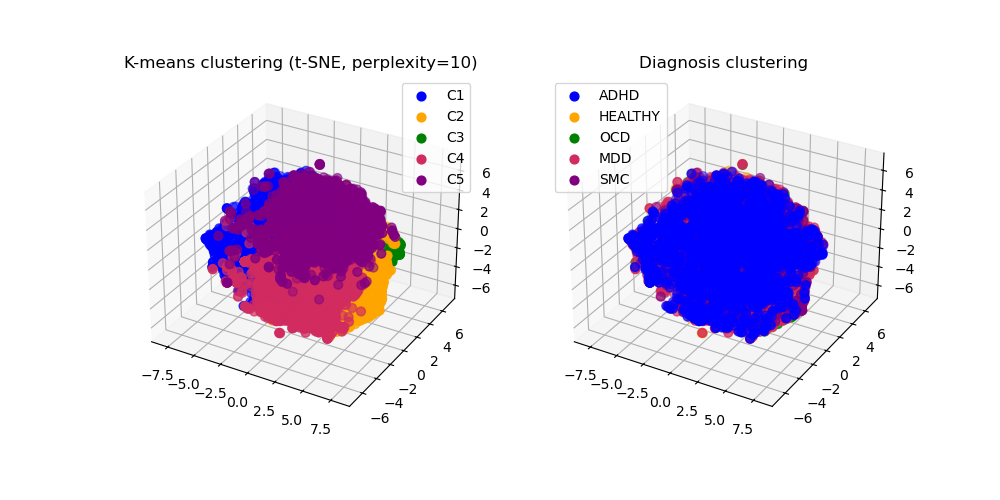

In [18]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

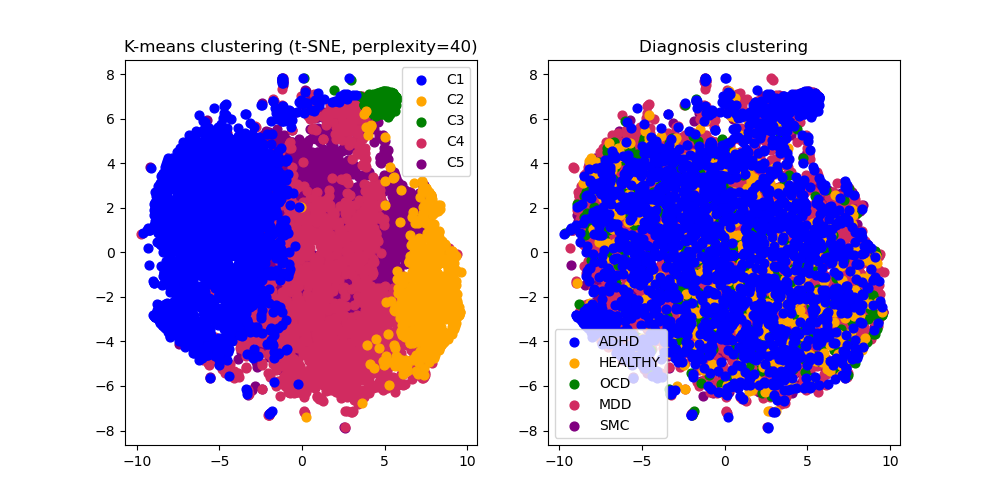

In [22]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

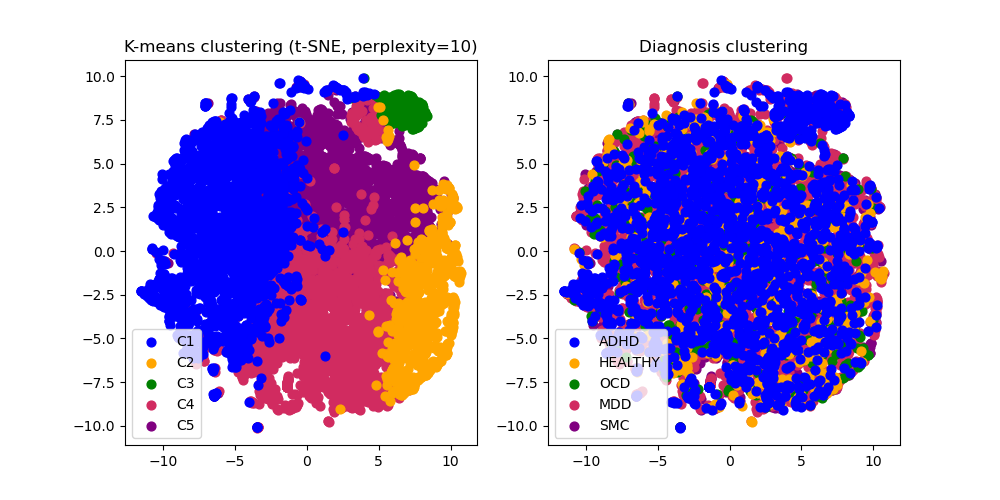

In [23]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

#### EC feature set

Text(0.5, 0.92, 'Cluster centers')

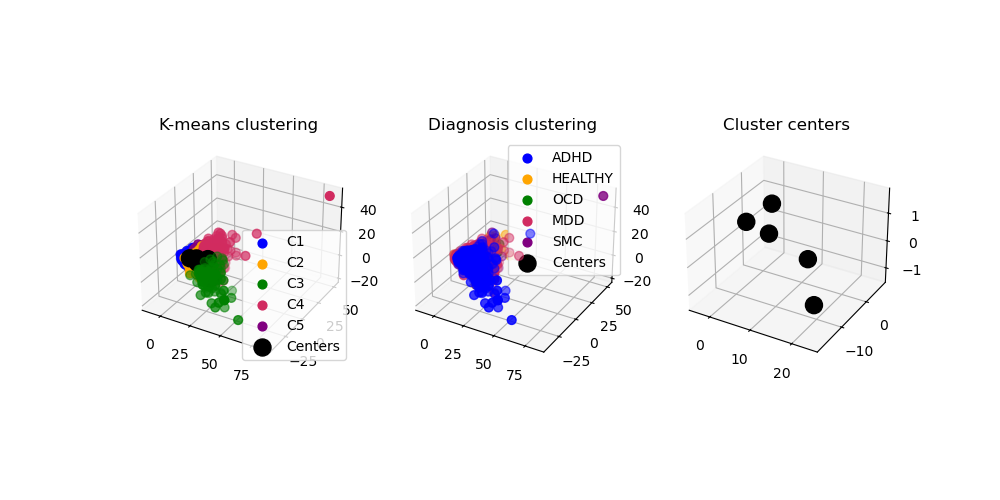

In [34]:
## K-means cluster analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

n_clusters = 5 # because 5 different classes/diagnoses

# define numeric columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

X = df_features_ec[numeric_cols]
X_scaled = numeric_transformer.fit_transform(X)
Y = df_features_ec['diagnosis']

# model
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled_clustered['cluster'] = clusters

from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 3 dimensions for visualisation
pca = PCA(n_components = 3)
X_reduced = pca.fit_transform(X_scaled) # transfer to 3D

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index = X.index, columns=['PC1','PC2', 'PC3'])
X_reduceddf['cluster'] = clusters

centres_reduced = pca.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,3,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_reduced[c1,0],X_reduced[c1,1],X_reduced[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_reduced[c2,0],X_reduced[c2,1],X_reduced[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_reduced[c3,0],X_reduced[c3,1],X_reduced[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_reduced[c4,0],X_reduced[c4,1],X_reduced[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_reduced[c5,0],X_reduced[c5,1],X_reduced[c5,2],c='purple',s=40,label="C5", zorder=1)
ax[0].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering')

ax[1].scatter(X_reduced[d1,0],X_reduced[d1,1],X_reduced[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_reduced[d2,0],X_reduced[d2,1],X_reduced[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_reduced[d3,0],X_reduced[d3,1],X_reduced[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_reduced[d4,0],X_reduced[d4,1],X_reduced[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_reduced[d5,0],X_reduced[d5,1],X_reduced[d5,2],c='purple',s=40,label="SMC", zorder=1)
ax[1].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

ax[2].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[2].set_title('Cluster centers')



Text(0.5, 0.92, 'Diagnosis clustering')

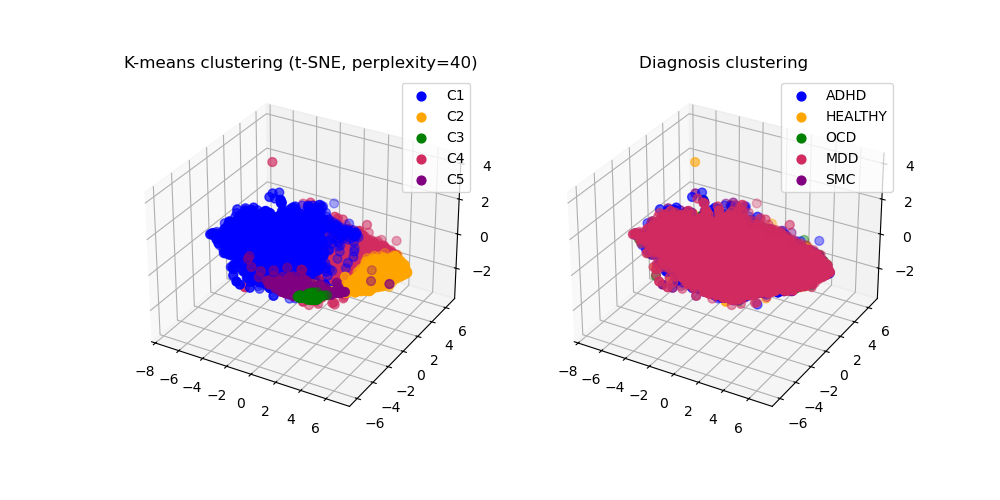

In [25]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 0.92, 'Diagnosis clustering')

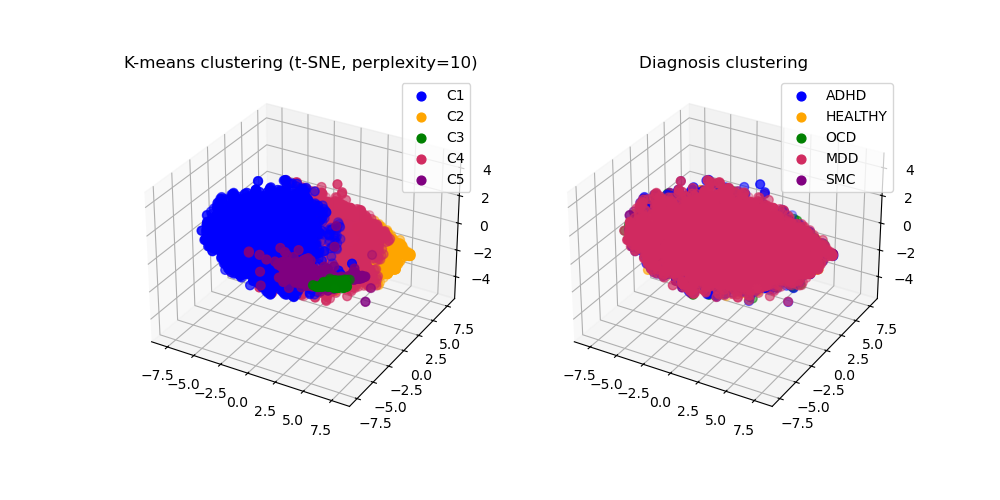

In [26]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

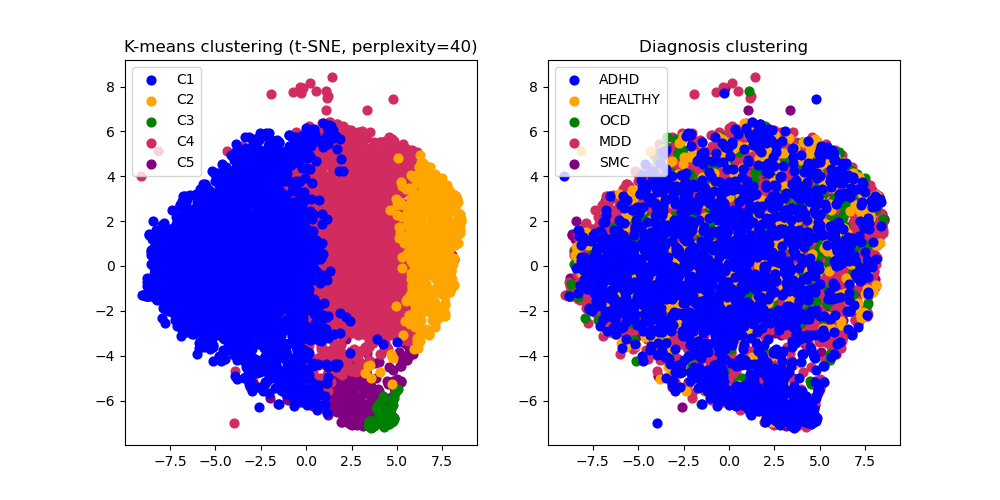

In [27]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

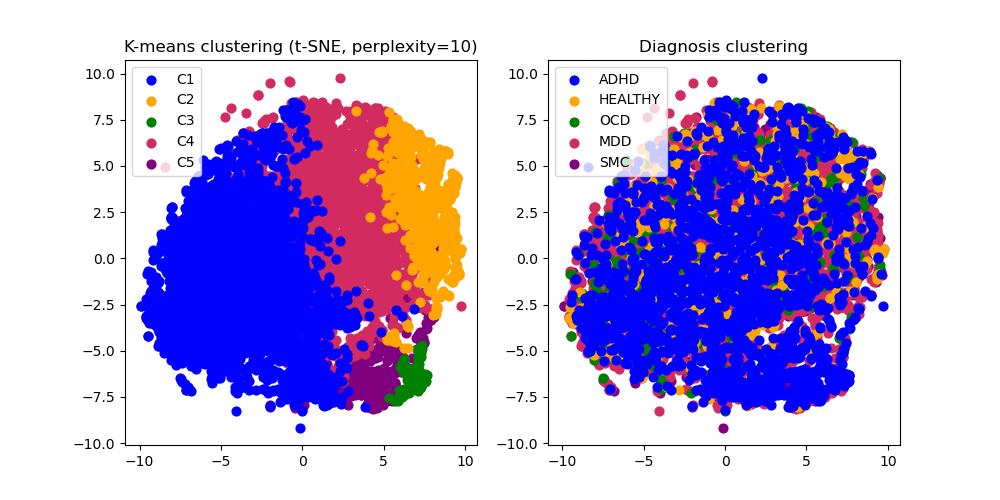

In [28]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

#### EO feature set

Text(0.5, 0.92, 'Cluster centers')

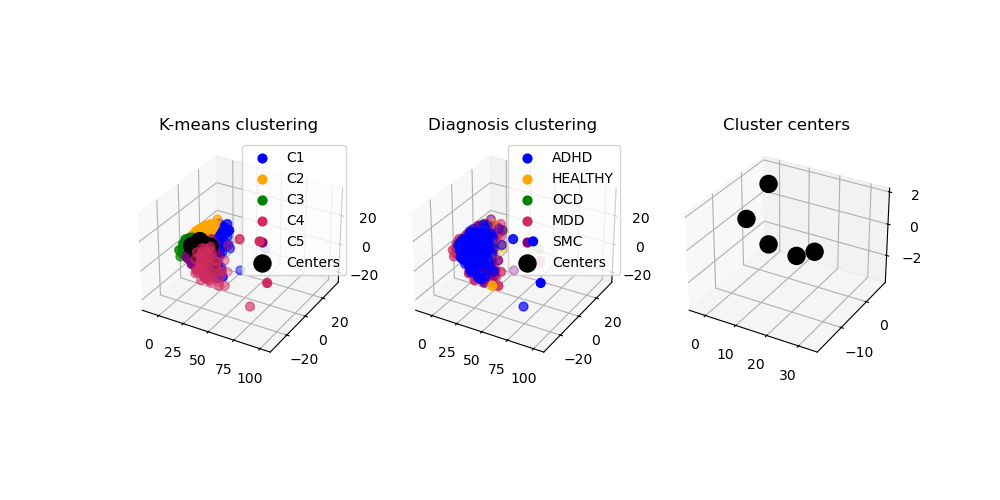

In [29]:
## K-means cluster analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

n_clusters = 5 # because 5 different classes/diagnoses

# define numeric columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

X = df_features_eo[numeric_cols]
X_scaled = numeric_transformer.fit_transform(X)
Y = df_features_eo['diagnosis']

# model
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled_clustered['cluster'] = clusters

from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 3 dimensions for visualisation
pca = PCA(n_components = 3)
X_reduced = pca.fit_transform(X_scaled) # transfer to 3D

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index = X.index, columns=['PC1','PC2', 'PC3'])
X_reduceddf['cluster'] = clusters

centres_reduced = pca.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,3,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_reduced[c1,0],X_reduced[c1,1],X_reduced[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_reduced[c2,0],X_reduced[c2,1],X_reduced[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_reduced[c3,0],X_reduced[c3,1],X_reduced[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_reduced[c4,0],X_reduced[c4,1],X_reduced[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_reduced[c5,0],X_reduced[c5,1],X_reduced[c5,2],c='purple',s=40,label="C5", zorder=1)
ax[0].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering')

ax[1].scatter(X_reduced[d1,0],X_reduced[d1,1],X_reduced[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_reduced[d2,0],X_reduced[d2,1],X_reduced[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_reduced[d3,0],X_reduced[d3,1],X_reduced[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_reduced[d4,0],X_reduced[d4,1],X_reduced[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_reduced[d5,0],X_reduced[d5,1],X_reduced[d5,2],c='purple',s=40,label="SMC", zorder=1)
ax[1].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

ax[2].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[2].set_title('Cluster centers')



Text(0.5, 0.92, 'Diagnosis clustering')

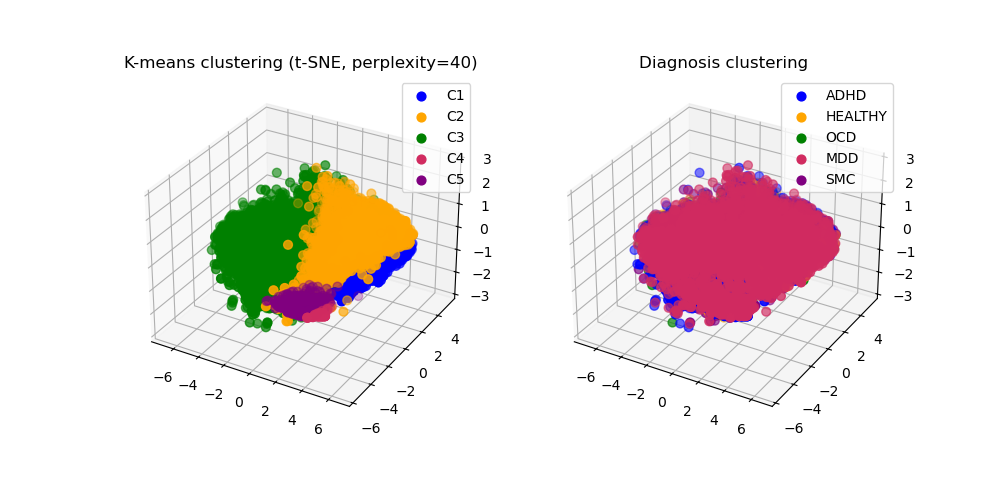

In [30]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

C:\Users\tuur\AppData\Local\Temp\ipykernel_2024\2540827309.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))


Text(0.5, 0.92, 'Diagnosis clustering')

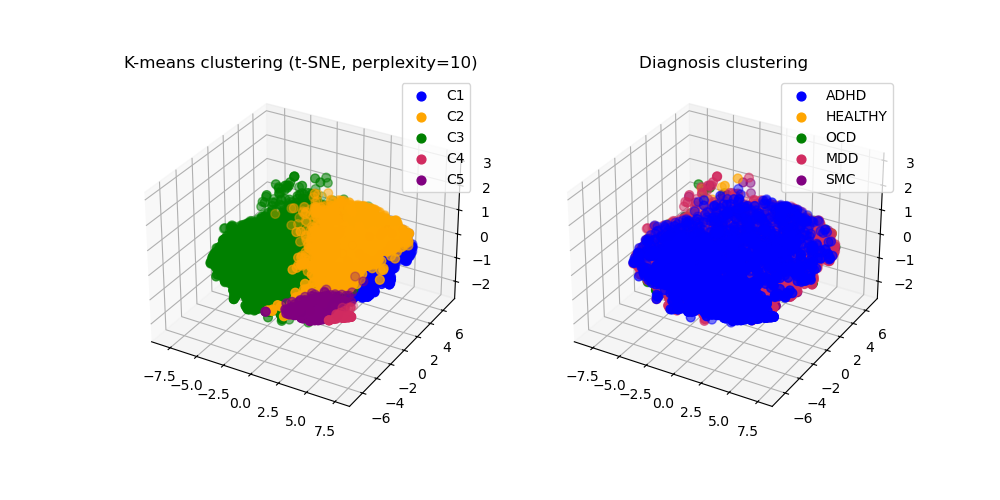

In [31]:
# Create t-SNE model for 3D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=3, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],X_tsne[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],X_tsne[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],X_tsne[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],X_tsne[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],X_tsne[c5,2],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],X_tsne[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],X_tsne[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],X_tsne[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],X_tsne[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],X_tsne[d5,2],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

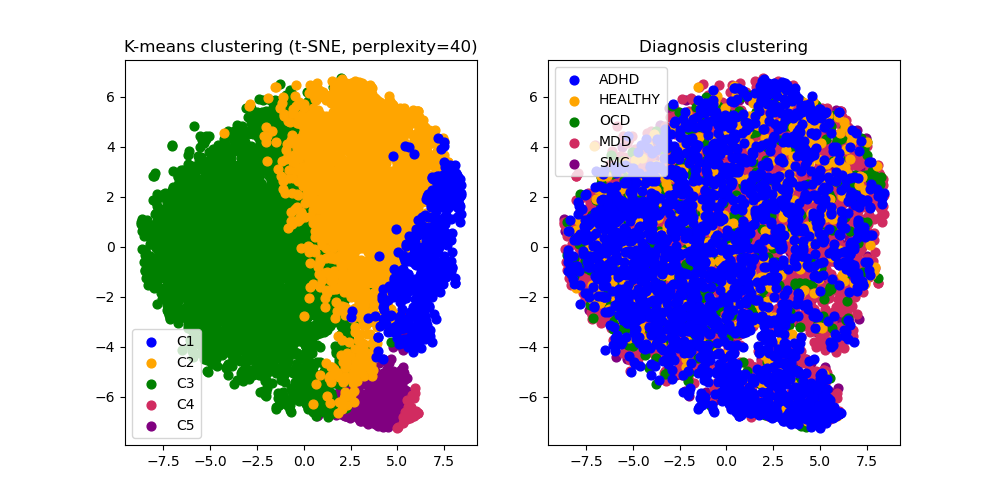

In [32]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=40)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')

Text(0.5, 1.0, 'Diagnosis clustering')

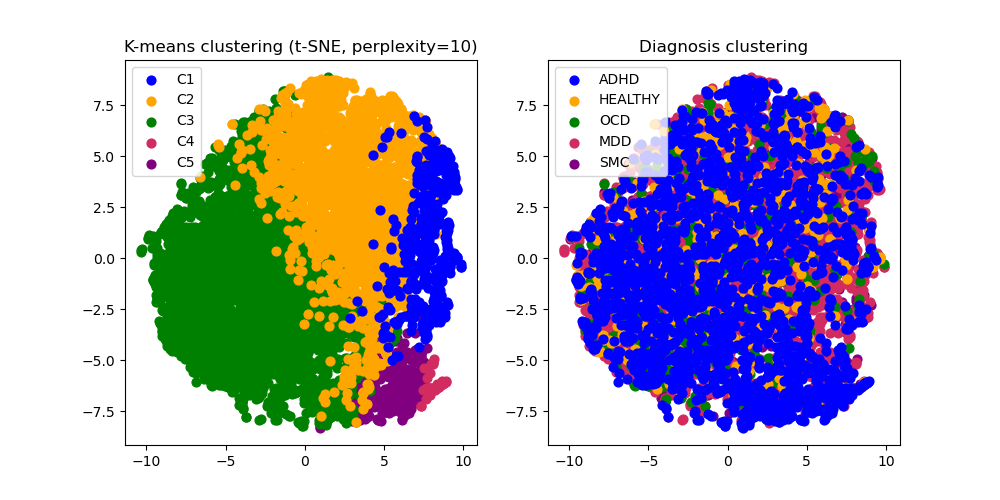

In [33]:
# Create t-SNE model for 2D visualisation
from sklearn.manifold import TSNE

# Create a PCA model to reduce our data to 50 dimensions before t-SNE
pca = PCA(n_components = 50)
X_reduced_50 = pca.fit_transform(X_scaled) # transfer to 50D

tsne = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_reduced_50)
# centers_tsne = tsne.transform(kmeans.cluster_centers_)


%matplotlib widget
fig, ax = plt.subplots(1,2,figsize=(10,5))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_tsne[c1,0],X_tsne[c1,1],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_tsne[c2,0],X_tsne[c2,1],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_tsne[c3,0],X_tsne[c3,1],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_tsne[c4,0],X_tsne[c4,1],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_tsne[c5,0],X_tsne[c5,1],c='purple',s=40,label="C5", zorder=1)
# ax[0].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering (t-SNE, perplexity=10)')

ax[1].scatter(X_tsne[d1,0],X_tsne[d1,1],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_tsne[d2,0],X_tsne[d2,1],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_tsne[d3,0],X_tsne[d3,1],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_tsne[d4,0],X_tsne[d4,1],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_tsne[d5,0],X_tsne[d5,1],c='purple',s=40,label="SMC", zorder=1)
# ax[1].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

# ax[2].scatter(centers_tsne[:,0],centers_tsne[:,1],centers_tsne[:,2],c="black",s=150,label="Centers",alpha=1)
# ax[2].set_title('Cluster centers')